## k-Nearest Neighbor (kNN) exercise
KNN分类器有两个阶段：
- 训练阶段：分类器只需要简单的记住所有训练数据
- 测试阶段：kNN通过与所有训练图像进行比较并转移k
个最相似的训练示例的标签来对每个测试图像进行分类

In [30]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 在执行用户代码前，重新装入 软件的扩展和模块
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


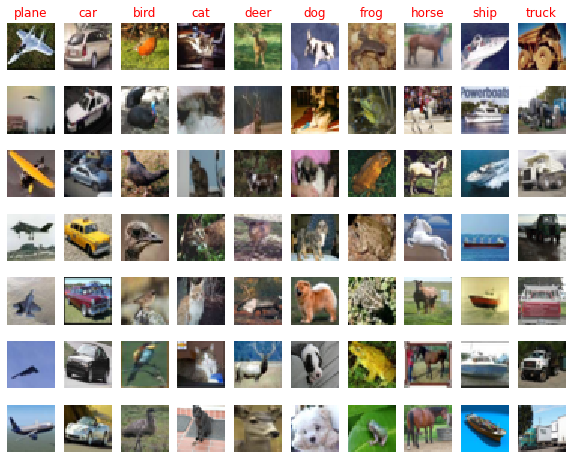

In [32]:
# 可视化一些数据集的例子
# 从训练数据的每个类别可视化几个案例
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero( y_train == y) # 返回扁平化后矩阵中非零元素的位置（index）
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls,color = 'red')

plt.show()

In [33]:
# 划分数据集
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 把图片数据拉成一行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [34]:
from cs231n.classifiers import KNearestNeighbor
# 创建一个knn分类器
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [35]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


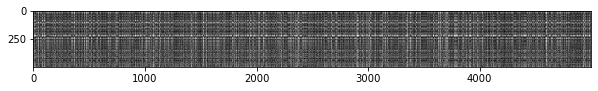

In [36]:
# 我们可以可视化距离矩阵：每一行都是一个测试示例
plt.imshow(dists, interpolation='none')
plt.show()

Inline Question #1: Notice the structured patterns in the distance matrix,
where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)
- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *- 如果第i个测试数据与大量的训练样本相似，第i行*

In [37]:
# k=1是近邻算法
y_test_pred = classifier.predict_labels(dists, k = 1)

# 计算正确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f'Got {num_correct} / {num_test}  correct => accuracy: {accuracy}')

Got 137 / 500  correct => accuracy: 0.274


In [38]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 139 / 500 correct => accuracy: 0.278000


**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$ *1,2*


$\color{blue}{\textit Your Explanation:}$


In [39]:
# 接下来加速矩阵计算，通过向量化操作
# 通过向量化简化成一次循环

dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们向量化实现是正确的，有很多方法决定矩阵是否相似
# 最简单的方法之一就是Frobenius范数 矩阵的F范式：各元素的绝对值平方和
# Frobenius范式就是所有元素差的平方和；

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('一次循环的矩阵差: %f' %(difference,))
if difference < 0.001:
    print('真不错！距离是相同的')
else:
    print('距离是不同的')

一次循环的矩阵差: 0.000000
真不错！距离是相同的


In [41]:
# 接下来是完全用向量化操作 compute_distances_no_loops
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('没有循环的矩阵差: %f' %(difference,))
if difference < 0.001:
    print('真不错！距离是相同的')
else:
    print('距离是不同的')

没有循环的矩阵差: 0.000000
真不错！距离是相同的


In [42]:
# 比较实现的方法是多少快

def time_function(f, *args):
    """
    用args调用函数f并返回执行所花费的时间（以秒为单位）。
    """
    import time
    start =time.time()
    f(*args)
    end = time.time()
    return end - start

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

#使用完全矢量化的实现，您应该会看到明显更快的性能！
#注意：根据您使用的机器，
#从两个循环转到一个循环时，您可能看不到加速，
#甚至可能会变慢。

Two loop version took 24.822887 seconds
One loop version took 48.405087 seconds
No loop version took 0.272040 seconds


### 交叉验证(Cross-validation)

我们已经实现了k最近邻居分类器，但是我们可以任意设置值k = 5。
现在，我们将通过交叉验证确定此超参数的最佳值。


In [64]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds =np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in range(num_folds):
    classifier = KNearestNeighbor()
    # 第i个为测试集，其余为训练集
    # combinat = [x for x in xrange(num_folds) if x != n]
    # x_training_dat = np.concatenate(X_train_folds[combinat])
    X_val_train = np.concatenate(X_train_folds[0:i] + X_train_folds[i+1:])
    y_val_train = np.concatenate(y_train_folds[0:i] + y_train_folds[i+1:])
    # X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
    # y_val_train = np.vstack(y_train_folds[0:i] + y_train_folds[i+1:])
    # y_val_train = y_val_train[:,0]

    classifier.train(X_val_train,y_val_train)
    for k in k_choices:
        y_val_pred = classifier.predict(X_train_folds[i], k=k) # 不能用predict_label
        num_correct = np.sum(y_val_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_val_pred)
        k_to_accuracies.setdefault(k,[]).append(accuracy)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

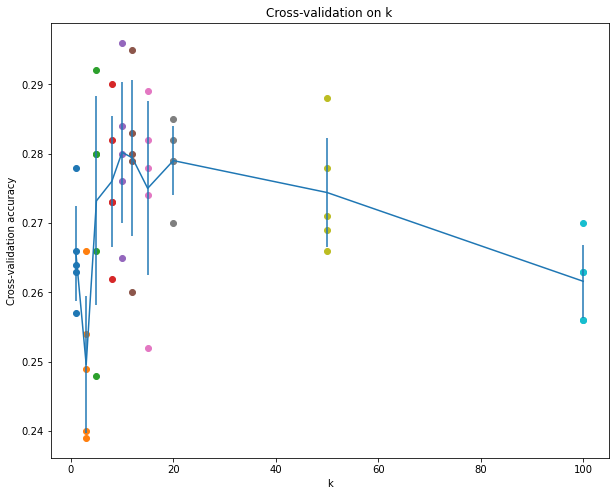

In [67]:
# 绘制观察结果
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [69]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
